# About run_sequence_analysis

This notebook creates dividies students into groups, loads their action sequences and runs the infogain analysis

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
%aimport utils_read_parsing
%aimport generalized_seq_miner
from utils_timeline_viz import *
from utils_read_parsing import *
from generalized_seq_miner import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 12,4
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
from itertools import groupby
from tabulate import tabulate
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
# FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

# Loading data

We grab the student learning data

In [2]:
df_all = get_df_all_factors(all_vars=False)
variables = list(set(df_all['variable']))
ids = list(set(df_all['sid']))
N = len(ids)
print 'We have',N,'students.'
print 'Running the analaysis on the following variables:',', '.join(variables)

We have 147 students.
Running the analaysis on the following variables: Width, Concentration, Separation, Area


We grab the sequences

In [3]:
import pickle
%aimport utils_sequence_parsing
from utils_sequence_parsing import Sequence
pickle_in_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_seqs.txt'),"r")
all_seqs = pickle.load(pickle_in_seqs)
pickle_in_seqs.close()

We transform the sequences by blocking certain actions, removing others, merging some and generalizing

In [4]:
transformed_seqs = {}
for sim,seqs_by_student in all_seqs.iteritems():
    transformed_seqs[sim] = {}
    for sid,seq in seqs_by_student.iteritems():
        seq = copy.copy(seq)
        seq.standard_transformation()
        transformed_seqs[sim][sid] = seq

# Splitting students

## Count number of "exact" main scores in each activity (1 and 2)

In [5]:
def count_exact(scores):
    return int(sum([s==2.0 for s in scores]))

In [6]:
scores = pd.pivot_table(df_all, values=['pre','main'], index=['sid','sim_index','sim'], aggfunc=count_exact)
scores.reset_index().set_index('sid',inplace=True)

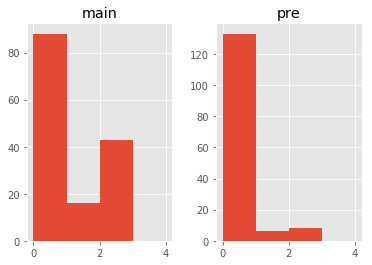

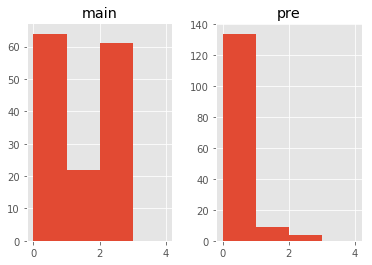

In [7]:
scores.groupby('sim_index').hist(bins=range(5));

## What if we split by increase or decrease in number of exact scores from pre to main?

In [8]:
def make_group(row):
    if row['pre']==2:
        return 'Hpre'
    elif row['pre']==0 and row['main']==0:
        return 'LU'
    elif row['pre']==0 and row['main']==1:
        return 'LP'
    elif row['pre']==0 and row['main']==2:
        return 'LP'
    elif row['pre']==1 and row['main']==0:
        return 'MU'
    elif row['pre']==1 and row['main']==1:
        return 'MU'
    elif row['pre']==1 and row['main']==2:
        return 'MP'
    else:
        print row
    
scores['rough group'] = scores.apply(make_group,axis=1)

In [9]:
scores.groupby(['sim_index','rough group']).describe()

main                                        pre       \
                      count  mean   std  min  25%  50%  75%  max count mean   
sim_index rough group                                                         
1         Hpre          8.0  2.00  0.00  2.0  2.0  2.0  2.0  2.0   8.0  2.0   
          LP           48.0  1.71  0.46  1.0  1.0  2.0  2.0  2.0  48.0  0.0   
          LU           85.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  85.0  0.0   
          MP            1.0  2.00   NaN  2.0  2.0  2.0  2.0  2.0   1.0  1.0   
          MU            5.0  0.40  0.55  0.0  0.0  0.0  1.0  1.0   5.0  1.0   
2         Hpre          4.0  1.50  1.00  0.0  1.5  2.0  2.0  2.0   4.0  2.0   
          LP           71.0  1.70  0.46  1.0  1.0  2.0  2.0  2.0  71.0  0.0   
          LU           63.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  63.0  0.0   
          MP            8.0  2.00  0.00  2.0  2.0  2.0  2.0  2.0   8.0  1.0   
          MU            1.0  1.00   NaN  1.0  1.0  1.0  1.0  1.0   1.0  1.0   

                                                     
                       std  min  25%  50%  75%  max  
sim_index rough group                                
1         Hpre         0.0  2.0  2.0  2.0  2.0  2.0  
          LP           0.0  0.0  0.0  0.0  0.0  0.0  
          LU           0.0  0.0  0.0  0.0  0.0  0.0  
          MP           NaN  1.0  1.0  1.0  1.0  1.0  
          MU           0.0  1.0  1.0  1.0  1.0  1.0  
2         Hpre         0.0  2.0  2.0  2.0  2.0  2.0  
          LP           0.0  0.0  0.0  0.0  0.0  0.0  
          LU           0.0  0.0  0.0  0.0  0.0  0.0  
          MP           0.0  1.0  1.0  1.0  1.0  1.0  
          MU           NaN  1.0  1.0  1.0  1.0  1.0

We bundle all those with some kind of high pre (Hpre, MU and MP)

In [10]:
def make_group(row):
    if row['pre']==2:
        return 'H'
    elif row['pre']==0 and row['main']==0:
        return 'LU'
    elif row['pre']==0 and row['main']==1:
        return 'LP'
    elif row['pre']==0 and row['main']==2:
        return 'LP'
    elif row['pre']==1 and row['main']==0:
        return 'H'
    elif row['pre']==1 and row['main']==1:
        return 'H'
    elif row['pre']==1 and row['main']==2:
        return 'H'
    else:
        print row
    
scores['group'] = scores.apply(make_group,axis=1)

In [11]:
scores.groupby(['sim_index','group']).describe()

main                                        pre              \
                count  mean   std  min  25%  50%  75%  max count  mean   std   
sim_index group                                                                
1         H      14.0  1.43  0.85  0.0  1.0  2.0  2.0  2.0  14.0  1.57  0.51   
          LP     48.0  1.71  0.46  1.0  1.0  2.0  2.0  2.0  48.0  0.00  0.00   
          LU     85.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  85.0  0.00  0.00   
2         H      13.0  1.77  0.60  0.0  2.0  2.0  2.0  2.0  13.0  1.31  0.48   
          LP     71.0  1.70  0.46  1.0  1.0  2.0  2.0  2.0  71.0  0.00  0.00   
          LU     63.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  63.0  0.00  0.00   

                                          
                 min  25%  50%  75%  max  
sim_index group                           
1         H      1.0  1.0  2.0  2.0  2.0  
          LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0  
2         H      1.0  1.0  1.0  2.0  2.0  
          LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0

In [12]:
scores.groupby(['sim','group']).describe()

main                                        pre                   \
          count  mean   std  min  25%  50%  75%  max count  mean   std  min   
sim group                                                                     
C   H      14.0  1.50  0.76  0.0  1.0  2.0  2.0  2.0  14.0  1.43  0.51  1.0   
    LP     53.0  1.62  0.49  1.0  1.0  2.0  2.0  2.0  53.0  0.00  0.00  0.0   
    LU     80.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  80.0  0.00  0.00  0.0   
L   H      13.0  1.69  0.75  0.0  2.0  2.0  2.0  2.0  13.0  1.46  0.52  1.0   
    LP     66.0  1.77  0.42  1.0  2.0  2.0  2.0  2.0  66.0  0.00  0.00  0.0   
    LU     68.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  68.0  0.00  0.00  0.0   

                               
           25%  50%  75%  max  
sim group                      
C   H      1.0  1.0  2.0  2.0  
    LP     0.0  0.0  0.0  0.0  
    LU     0.0  0.0  0.0  0.0  
L   H      1.0  1.0  2.0  2.0  
    LP     0.0  0.0  0.0  0.0  
    LU     0.0  0.0  0.0  0.0

By sim index and by sim order, there are too few Highpres to include them so we group them.

In [13]:
scores = scores[scores['group'].isin(['LU','LP'])]
scores.groupby(['sim_index','group']).describe()

main                                        pre            \
                count  mean   std  min  25%  50%  75%  max count mean  std   
sim_index group                                                              
1         LP     48.0  1.71  0.46  1.0  1.0  2.0  2.0  2.0  48.0  0.0  0.0   
          LU     85.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  85.0  0.0  0.0   
2         LP     71.0  1.70  0.46  1.0  1.0  2.0  2.0  2.0  71.0  0.0  0.0   
          LU     63.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  63.0  0.0  0.0   

                                          
                 min  25%  50%  75%  max  
sim_index group                           
1         LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0  
2         LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0

### How to people transition from one group to another from activity 1 to 2?

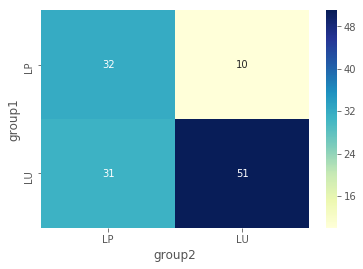

In [14]:
df_all = df_all.merge(scores[['group']], how='outer', on=['sid','sim_index']);
df_all.dropna(inplace=True)
combogroups = df_all[df_all['sim_index']==1][['sid','group']].rename(columns={'group':'group1'}).merge(df_all[df_all['sim_index']==2][['sid','group']].rename(columns={'group':'group2'}), how='outer', on=['sid']);
combogroups.drop_duplicates(inplace=True)
sns.heatmap(pd.pivot_table(combogroups, index='group1',columns='group2',values='sid',aggfunc=len),cmap="YlGnBu",annot=True)#.fillna(0))

The bulk of students go from LU to LP or remain in their original group.

# Running analysis

## Making decisions on sim/order to use

We limit it to the first activity

In [39]:
df_all.groupby(['sim_index','sim']).describe()

sid                                                    \
               count      mean       std       min       25%       50%   
sim_index sim                                                            
1         C    124.0  1.91e+07  1.37e+07  1.02e+07  1.31e+07  1.68e+07   
          L    142.0  2.33e+07  1.89e+07  1.01e+07  1.37e+07  1.68e+07   
2         C    142.0  2.25e+07  1.84e+07  1.02e+07  1.37e+07  1.66e+07   
          L    126.0  2.05e+07  1.64e+07  1.02e+07  1.31e+07  1.70e+07   

                                     pre                                       \
                    75%       max  count  mean   std  min  25%  50%  75%  max   
sim_index sim                                                                   
1         C    1.92e+07  8.59e+07  124.0  0.32  0.47  0.0  0.0  0.0  1.0  1.0   
          L    1.95e+07  8.90e+07  142.0  0.23  0.42  0.0  0.0  0.0  0.0  1.0   
2         C    1.93e+07  8.90e+07  142.0  0.35  0.48  0.0  0.0  0.0  1.0  1.0   
          L    1.93e+07  8.59e+07  126.0  0.30  0.46  0.0  0.0  0.0  1.0  1.0   

                main                                      cvs_graph        \
               count  mean   std  min  25%  50%  75%  max     count  mean   
sim_index sim                                                               
1         C    124.0  1.18  0.57  0.0  1.0  1.0  2.0  2.0     124.0  0.34   
          L    142.0  1.22  0.65  0.0  1.0  1.0  2.0  2.0     142.0  0.43   
2         C    142.0  1.28  0.62  0.0  1.0  1.0  2.0  2.0     142.0  0.50   
          L    126.0  1.47  0.63  0.0  1.0  2.0  2.0  2.0     126.0  0.51   

                                             cvs_table                        \
                std  min  25%  50%  75%  max     count  mean   std  min  25%   
sim_index sim                                                                  
1         C    0.48  0.0  0.0  0.0  1.0  1.0     124.0  0.50  0.50  0.0  0.0   
          L    0.50  0.0  0.0  0.0  1.0  1.0     142.0  0.62  0.49  0.0  0.0   
2         C    0.50  0.0  0.0  0.5  1.0  1.0     142.0  0.63  0.49  0.0  0.0   
          L    0.50  0.0  0.0  1.0  1.0  1.0     126.0  0.60  0.49  0.0  0.0   

                             cvs_table_only                                  \
               50%  75%  max          count  mean   std  min  25%  50%  75%   
sim_index sim                                                                 
1         C    0.5  1.0  1.0          124.0  0.16  0.37  0.0  0.0  0.0  0.0   
          L    1.0  1.0  1.0          142.0  0.19  0.39  0.0  0.0  0.0  0.0   
2         C    1.0  1.0  1.0          142.0  0.13  0.33  0.0  0.0  0.0  0.0   
          L    1.0  1.0  1.0          126.0  0.10  0.29  0.0  0.0  0.0  0.0   

                   cvs_graph_inverse                                       \
               max             count  mean   std  min  25%  50%  75%  max   
sim_index sim                                                               
1         C    1.0             124.0  0.21  0.41  0.0  0.0  0.0  0.0  1.0   
          L    1.0             142.0  0.10  0.30  0.0  0.0  0.0  0.0  1.0   
2         C    1.0             142.0  0.21  0.41  0.0  0.0  0.0  0.0  1.0   
          L    1.0             126.0  0.06  0.24  0.0  0.0  0.0  0.0  1.0   

              cvs_graph_axes                                      qual_score  \
                       count  mean   std  min  25%  50%  75%  max      count   
sim_index sim                                                                  
1         C            124.0  0.55  0.82  0.0  0.0  0.0  1.0  2.0      124.0   
          L            142.0  0.53  0.67  0.0  0.0  0.0  1.0  2.0      142.0   
2         C            142.0  0.71  0.80  0.0  0.0  0.5  1.0  2.0      142.0   
          L            126.0  0.57  0.61  0.0  0.0  1.0  1.0  2.0      126.0   

                                                   quant_score              \
               mean   std  min  25%  50%  75%  max       count  mean   std   
sim_index sim     

In [51]:
sim = 'both' #'both', 'L', 'C'
order = 2 # 1 or 2 as an int
dict_sim_names = {'L':'beers','C':'capacitor'}

In [52]:
def get_levels_and_students_per_attribute(df, attribute):
    d={}
    levels = list(df[attribute].unique())
    for level in levels:
        d[level] = list(df[df[attribute]==level]['sid'].unique())
    return levels,d
    
if sim != 'both' and order != 'both': 
    print 'here1'
    df = df_all[(df_all['sim_index']==order)|(df_all['sim']==sim)]
elif order != 'both':
    print 'here2'
    df = df_all[df_all['sim_index']==order]
elif sim != 'both':
    print 'here3'
    df = df_all[(df_all['sim']==sim)]
else:
    print "YOU MUST CHOOSE ONE AS \'BOTH\'"

print "We are analyzing {0} students:".format(len(df['sid'].unique()))

# levels, students_by_attribute = get_levels_and_students_per_attribute(df[df['variable']=='Concentration'], 'group')
levels, students_by_attribute = get_levels_and_students_per_attribute(df, 'group')
for level in levels:
    print level, len(students_by_attribute[level])

here2
We are analyzing 134 students:
LP 71
LU 63


In [64]:
df.groupby(['sim','group','sim_index','variable']).describe()

sid                                \
                                  count      mean       std       min   
sim group sim_index variable                                            
C   LP    2         Area           33.0  1.86e+07  1.18e+07  1.02e+07   
                    Separation     33.0  1.86e+07  1.18e+07  1.02e+07   
    LU    2         Area           38.0  2.59e+07  2.23e+07  1.09e+07   
                    Separation     38.0  2.59e+07  2.23e+07  1.09e+07   
L   LP    2         Concentration  38.0  2.17e+07  1.81e+07  1.02e+07   
                    Width          38.0  2.17e+07  1.81e+07  1.02e+07   
    LU    2         Concentration  25.0  1.87e+07  1.38e+07  1.04e+07   
                    Width          25.0  1.87e+07  1.38e+07  1.04e+07   

                                                                           \
                                        25%       50%       75%       max   
sim group sim_index variable                                                
C   LP    2         Area           1.37e+07  1.63e+07  1.90e+07  7.90e+07   
                    Separation     1.37e+07  1.63e+07  1.90e+07  7.90e+07   
    LU    2         Area           1.37e+07  1.71e+07  1.96e+07  8.90e+07   
                    Separation     1.37e+07  1.71e+07  1.96e+07  8.90e+07   
L   LP    2         Concentration  1.29e+07  1.68e+07  1.96e+07  8.59e+07   
                    Width          1.29e+07  1.68e+07  1.96e+07  8.59e+07   
    LU    2         Concentration  1.36e+07  1.70e+07  1.86e+07  8.28e+07   
                    Width          1.36e+07  1.70e+07  1.86e+07  8.28e+07   

                                    pre                                        \
                                  count  mean   std  min  25%  50%   75%  max   
sim group sim_index variable                                                    
C   LP    2         Area           33.0  0.39  0.50  0.0  0.0  0.0  1.00  1.0   
                    Separation     33.0  0.45  0.51  0.0  0.0  0.0  1.00  1.0   
    LU    2         Area           38.0  0.29  0.46  0.0  0.0  0.0  1.00  1.0   
                    Separation     38.0  0.26  0.45  0.0  0.0  0.0  0.75  1.0   
L   LP    2         Concentration  38.0  0.32  0.47  0.0  0.0  0.0  1.00  1.0   
                    Width          38.0  0.21  0.41  0.0  0.0  0.0  0.00  1.0   
    LU    2         Concentration  25.0  0.40  0.50  0.0  0.0  0.0  1.00  1.0   
                    Width          25.0  0.32  0.48  0.0  0.0  0.0  1.00  1.0   

                                   main                                       \
                                  count  mean   std  min  25%  50%  75%  max   
sim group sim_index variable                                                   
C   LP    2         Area           33.0  1.85  0.36  1.0  2.0  2.0  2.0  2.0   
                    Separation     33.0  1.70  0.59  0.0  2.0  2.0  2.0  2.0   
    LU    2         Area           38.0  0.87  0.34  0.0  1.0  1.0  1.0  1.0   
                    Separation     38.0  0.84  0.37  0.0  1.0  1.0  1.0  1.0   
L   LP    2         Concentration  38.0  1.92  0.36  0.0  2.0  2.0  2.0  2.0   
                    Width          38.0  1.79  0.53  0.0  2.0  2.0  2.0  2.0   
    LU    2         Concentration  25.0  0.88  0.33  0.0  1.0  1.0  1.0  1.0   
                    Width          25.0  0.88  0.33  0.0  1.0  1.0  1.0  1.0   

                                  cvs_graph                                   \
                                      count  mean   std  min   25%  50%  75%   
sim group sim_index variable                                                   
C   LP    2         Area               33.0  0.79  0.42  0.0  1.00  1.0  1.0   
                    Separation         33.0  0.76  0.44  0.0  1.00  1.0  1.0   
    LU    2         Area               38.0  0.29  0.46  0.0  0.00  0.0  1.0   
                    Separation         38.0  0.24  0.43  0.0  0.00  0.0  0.0   
L   LP    2         Concentration      38.0  0.74  

In [56]:
seqs_dict = {}
timecoords_dict = {}

for i,row in df[['sid','sim']].drop_duplicates().iterrows():
    sim = dict_sim_names[row['sim']]
    sid = row['sid']
    seqs_dict[sid] = transformed_seqs[sim][sid].seq
    start_times = transformed_seqs[sim][sid].timecoords
    #add durations
    timecoords_dict[sid] = [(round(t,3),round(start_times[i+1]-t,3)) if i<len(start_times)-1 else (t,1) for i,t in enumerate(start_times)]

In [57]:
print len(seqs_dict)

134


## Setting parameters

In [58]:
attribute = 'group'
level1 = 'LU'
level2 = 'LP'
#We split activities into 3 time bins
num_bins = 3
#Sequences of action of interest can be a minimum and max length
shortest_seq_length = 1
longest_seq_length = 10
# for mining sequences in large groups, we want to make sure we find interesting sequences that have been done by a minimum number of people.
# Thus we use a cut off of 0.3-0.5 to only analyze sequences done by at least 30-50% of students within a group.
# Thus the groups can have slightly different sizes.
cut_off = 0.33

## Running the sequence mining

In [59]:
%aimport generalized_seq_miner
freqs = get_frequencies_by_bin(seqs_dict,timecoords_dict, num_bins, shortest=shortest_seq_length, longest=longest_seq_length)
# The code below finds, for each sequence, the number of students in each group that used that sequence at least once in that time bin
# For instance, for the sequence 'BCB': array([[ .2,  1.],[ 1.,  0.]]), it was used at least once by 2 of the students in the "passed" group in the first half of their activity.
seq_use = get_sequence_use_by_timebin(seqs_dict,timecoords_dict, students_by_attribute, num_bins, attribute,
            levels, shortest_seq_length, longest_seq_length, cut_off)
## Now we can calculate the information gain of this sequence over groups in time. In other words, high information gain sequences
# are used differently over time by groups while low information gain sequences are used closer to randomly by groups over time.
tops = rank_sequences(seq_use,num_bins)[-10:]
tops.sort(key=lambda tup: tup[1],reverse=True)
# for s,f in tops:
#     print round(f,3),'\t',s

## Make viz

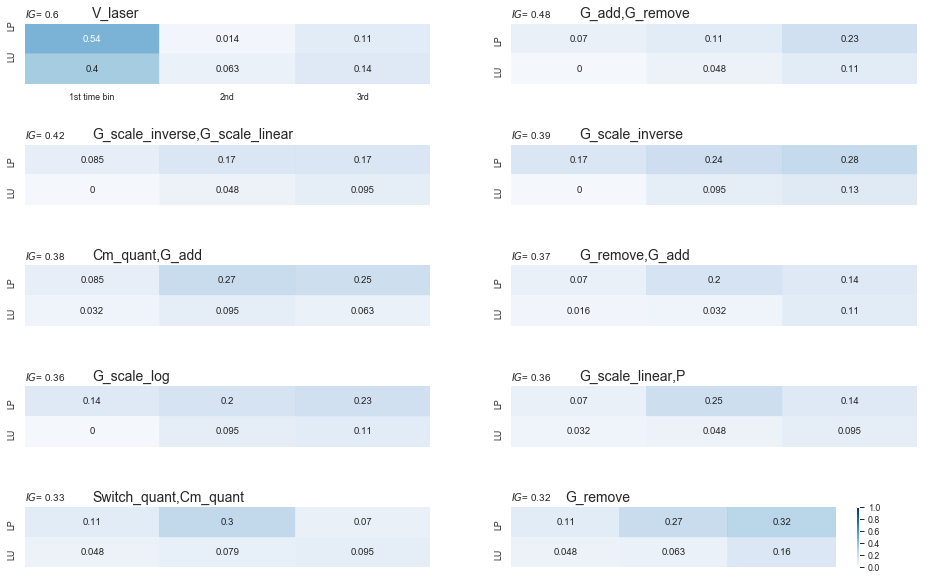

In [60]:
sns.set_style("darkgrid")
sns.set_context("paper")
seqs_plot = zip(*tops)[0]
fig, axes = plt.subplots(len(seqs_plot)/2,2,figsize=(16,len(tops)))#, sharex=True, sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

# maximum = int(max([np.amax(counts) for seq,counts in seq_use.iteritems() if seq in seqs_plot]))
Ns = np.zeros((len(levels),num_bins))
Ns[0,:].fill(len(students_by_attribute[level2])); Ns[1,:].fill(len(students_by_attribute[level1]))
maximum = 1

for i,(seq,ig) in enumerate(tops):
    ax = axes.flatten()[i]
    data = seq_use[seq]
    ax.text(0.5,-0.2, seq, fontsize=14)
    ax.text(0,-0.2, "$IG$= {0}".format(str(round(ig,2))), fontsize=10)
    
    # heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.8, vmin=0)
    heatmap = sns.heatmap(np.divide(data,Ns), ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=True) #, annot_kws={'fontweight':'bold'})

    if i==0:
        xlabels = map(str, np.arange(data.shape[1])+1) 
        xlabels = ['1st time bin','2nd','3rd']
        ax.set_xticklabels([],)
        ax.set_xticks(np.arange(data.shape[1]) + 0.5)
        ax.set_xticklabels(xlabels)
        ax.set_yticks(np.arange(data.shape[0]))
        cbar = ax.figure.colorbar(ax.collections[0])
#         cbar.set_ticks([0,1,3,5,7,9,11,13])
#         cbar.set_ticklabels([0,1,3,5,7,9,11,13])
    else: 
        ax.set_xticklabels(['','','',''])
        ax.set_yticklabels(['',''])
        
    ylabels = ['LP','LU']
    ax.set_yticklabels(ylabels)

        

#     cbar = ax.figure.colorbar(ax.collections[0])
#     cbar.set_ticks([0,1,3,5,7,9,11,13])
#     cbar.set_ticklabels([0,1,3,5,7,9,11,13])

#     fig.set_size_inches(4,1.6*len(all_seqs))
#     ax.set_frame_on(False)
#     ax.tick_params(
#         axis='both',        # changes apply to both the x and y-axis
#         which='both',       # both major and minor ticks are affected
#         bottom='off',       # ticks along the those edges are off
#         right='off', 
#         left='off',
#         top='off') 
# fig.savefig('heatmap_all.svg')

# Running sequence analysis for LULU and LULP

In [122]:
levels = ['LULU','LULP']

students_by_attribute={}
students_by_attribute['LULU'] = list(combogroups[(combogroups['group1']=='LU')&(combogroups['group2']=='LU')]['sid'].unique())
students_by_attribute['LULP'] = list(combogroups[(combogroups['group1']=='LU')&(combogroups['group2']=='LP')]['sid'].unique())

for level in levels:
    print level, len(students_by_attribute[level])
    
df = df_all[(df_all['sid'].isin(students_by_attribute['LULU'])) | (df_all['sid'].isin(students_by_attribute['LULP']))]
df = df[df['sim_index']==1]
df.groupby(['sim_index','group','variable']).describe()

LULU 51
LULP 31


sid                                          \
                              count      mean       std       min       25%   
sim_index group variable                                                      
1         LU    Area           40.0  1.83e+07  1.24e+07  1.02e+07  1.31e+07   
                Concentration  42.0  2.22e+07  2.01e+07  1.02e+07  1.32e+07   
                Separation     40.0  1.83e+07  1.24e+07  1.02e+07  1.31e+07   
                Width          42.0  2.22e+07  2.01e+07  1.02e+07  1.32e+07   

                                                              pre              \
                                    50%       75%       max count  mean   std   
sim_index group variable                                                        
1         LU    Area           1.59e+07  1.87e+07  8.28e+07  40.0  0.17  0.38   
                Concentration  1.60e+07  1.87e+07  8.90e+07  42.0  0.17  0.38   
                Separation     1.59e+07  1.87e+07  8.28e+07  40.0  0.40  0.50   
                Width          1.60e+07  1.87e+07  8.90e+07  42.0  0.14  0.35   

                                                        main                   \
                               min  25%  50%  75%  max count  mean   std  min   
sim_index group variable                                                        
1         LU    Area           0.0  0.0  0.0  0.0  1.0  40.0  0.88  0.33  0.0   
                Concentration  0.0  0.0  0.0  0.0  1.0  42.0  0.88  0.33  0.0   
                Separation     0.0  0.0  0.0  1.0  1.0  40.0  0.93  0.27  0.0   
                Width          0.0  0.0  0.0  0.0  1.0  42.0  0.79  0.42  0.0   

                                                  cvs_graph                   \
                               25%  50%  75%  max     count  mean   std  min   
sim_index group variable                                                       
1         LU    Area           1.0  1.0  1.0  1.0      40.0  0.17  0.38  0.0   
                Concentration  1.0  1.0  1.0  1.0      42.0  0.33  0.48  0.0   
                Separation     1.0  1.0  1.0  1.0      40.0  0.23  0.42  0.0   
                Width          1.0  1.0  1.0  1.0      42.0  0.19  0.40  0.0   

                                                  cvs_table                   \
                               25%  50%  75%  max     count  mean   std  min   
sim_index group variable                                                       
1         LU    Area           0.0  0.0  0.0  1.0      40.0  0.40  0.50  0.0   
                Concentration  0.0  0.0  1.0  1.0      42.0  0.50  0.51  0.0   
                Separation     0.0  0.0  0.0  1.0      40.0  0.40  0.50  0.0   
                Width          0.0  0.0  0.0  1.0      42.0  0.45  0.50  0.0   

                                                  cvs_table_only              \
                               25%  50%  75%  max          count  mean   std   
sim_index group variable                                                       
1         LU    Area           0.0  0.0  1.0  1.0           40.0  0.23  0.42   
                Concentration  0.0  0.5  1.0  1.0           42.0  0.17  0.38   
                Separation     0.0  0.0  1.0  1.0           40.0  0.17  0.38   
                Width          0.0  0.0  1.0  1.0           42.0  0.26  0.45   

                                                        cvs_graph_inverse  \
                               min  25%  50%   75%  max             count   
sim_index group variable                                                    
1         LU    Area           0.0  0.0  0.0  0.00  1.0              40.0   
                Concentration  0.0  0.0  0.0  0.00  1.0              42.0   
                Separation     0.0  0.0  0.0  0.00  1.0              40.0   
                Width          0.0  0.0  0.0  0.75  1.0              42.0   

                                                                    \
                               mean   std  min  2

In [123]:
seqs_dict = {}
timecoords_dict = {}

for i,row in df[['sid','sim']].drop_duplicates().iterrows():
    sim = dict_sim_names[row['sim']]
    sid = row['sid']
    seqs_dict[sid] = transformed_seqs[sim][sid].seq
    start_times = transformed_seqs[sim][sid].timecoords
    #add durations
    timecoords_dict[sid] = [(round(t,3),round(start_times[i+1]-t,3)) if i<len(start_times)-1 else (t,1) for i,t in enumerate(start_times)]

In [124]:
len(seqs_dict)

82

In [125]:
level1 = 'LULU'
level2 = 'LULP'
#We split activities into 3 time bins
num_bins = 3
#Sequences of action of interest can be a minimum and max length
shortest_seq_length = 1
longest_seq_length = 10
# for mining sequences in large groups, we want to make sure we find interesting sequences that have been done by a minimum number of people.
# Thus we use a cut off of 0.3-0.5 to only analyze sequences done by at least 30-50% of students within a group.
# Thus the groups can have slightly different sizes.
cut_off = 0.33

In [126]:
%aimport generalized_seq_miner
freqs = get_frequencies_by_bin(seqs_dict,timecoords_dict, num_bins, shortest=shortest_seq_length, longest=longest_seq_length)
# The code below finds, for each sequence, the number of students in each group that used that sequence at least once in that time bin
# For instance, for the sequence 'BCB': array([[ .2,  1.],[ 1.,  0.]]), it was used at least once by 2 of the students in the "passed" group in the first half of their activity.
seq_use = get_sequence_use_by_timebin(seqs_dict,timecoords_dict, students_by_attribute, num_bins, attribute,
            levels, shortest_seq_length, longest_seq_length, cut_off)
## Now we can calculate the information gain of this sequence over groups in time. In other words, high information gain sequences
# are used differently over time by groups while low information gain sequences are used closer to randomly by groups over time.
tops = rank_sequences(seq_use,num_bins)[-10:]
tops.sort(key=lambda tup: tup[1],reverse=True)
# for s,f in tops:
#     print round(f,3),'\t',s

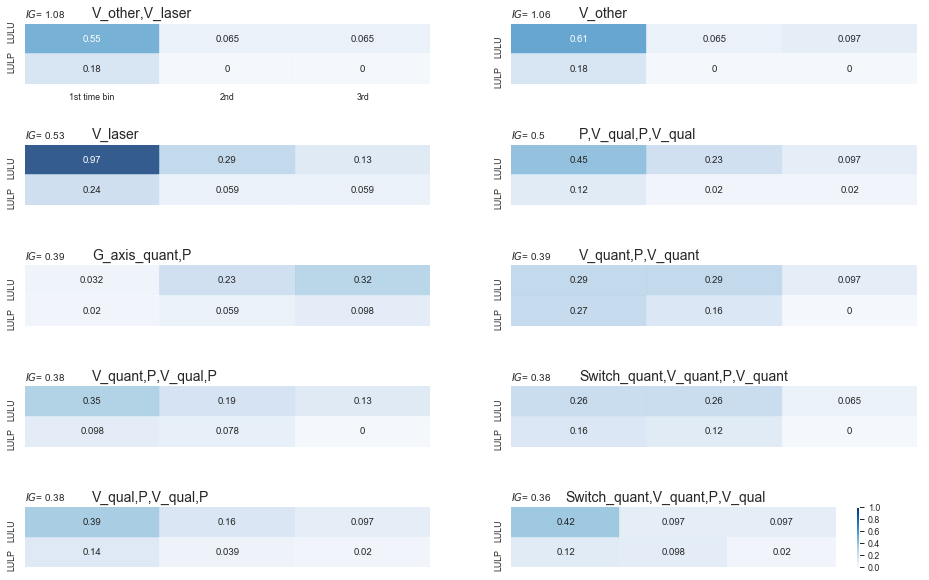

In [127]:
sns.set_style("darkgrid")
sns.set_context("paper")
seqs_plot = zip(*tops)[0]
fig, axes = plt.subplots(len(seqs_plot)/2,2,figsize=(16,len(tops)))#, sharex=True, sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

# maximum = int(max([np.amax(counts) for seq,counts in seq_use.iteritems() if seq in seqs_plot]))
Ns = np.zeros((len(levels),num_bins))
Ns[0,:].fill(len(students_by_attribute[level2])); Ns[1,:].fill(len(students_by_attribute[level1]))
maximum = 1

for i,(seq,ig) in enumerate(tops):
    ax = axes.flatten()[i]
    data = seq_use[seq]
    ax.text(0.5,-0.2, seq, fontsize=14)
    ax.text(0,-0.2, "$IG$= {0}".format(str(round(ig,2))), fontsize=10)
    
    # heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.8, vmin=0)
    heatmap = sns.heatmap(np.divide(data,Ns), ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=True)

    if i==0:
        xlabels = map(str, np.arange(data.shape[1])+1) 
        xlabels = ['1st time bin','2nd','3rd']
        ax.set_xticklabels([],)
        ax.set_xticks(np.arange(data.shape[1]) + 0.5)
        ax.set_xticklabels(xlabels)
        ax.set_yticks(np.arange(data.shape[0]))
        cbar = ax.figure.colorbar(ax.collections[0])
#         cbar.set_ticks([0,1,3,5,7,9,11,13])
#         cbar.set_ticklabels([0,1,3,5,7,9,11,13])
    else: 
        ax.set_xticklabels(['','','',''])
        ax.set_yticklabels(['',''])
        
    ylabels = levels
    ax.set_yticklabels(ylabels)

        

#     cbar = ax.figure.colorbar(ax.collections[0])
#     cbar.set_ticks([0,1,3,5,7,9,11,13])
#     cbar.set_ticklabels([0,1,3,5,7,9,11,13])

#     fig.set_size_inches(4,1.6*len(all_seqs))
#     ax.set_frame_on(False)
#     ax.tick_params(
#         axis='both',        # changes apply to both the x and y-axis
#         which='both',       # both major and minor ticks are affected
#         bottom='off',       # ticks along the those edges are off
#         right='off', 
#         left='off',
#         top='off') 
# fig.savefig('heatmap_all.svg')

# Comparison tests of single actions and seqs

In [24]:
sim = 'L' #'both', 'L', 'C'
order = 'both' # 1 or 2 as an int
dict_sim_names = {'L':'beers','C':'capacitor'}

In [25]:
def get_levels_and_students_per_attribute(df, attribute):
    d={}
    levels = list(df[attribute].unique())
    for level in levels:
        d[level] = list(df[df[attribute]==level]['sid'].unique())
    return levels,d
    
if sim != 'both' and order != 'both': 
    print 'here1'
    df = df_all[(df_all['sim_index']==order)|(df_all['sim']==sim)]
elif order != 'both':
    print 'here2'
    df = df_all[df_all['sim_index']==order]
elif sim != 'both':
    print 'here3'
    df = df_all[(df_all['sim']==sim)]
else:
    print "YOU MUST CHOOSE ONE AS \'BOTH\'"

print "We are analyzing {0} students:".format(len(df['sid'].unique()))

# levels, students_by_attribute = get_levels_and_students_per_attribute(df[df['variable']=='Concentration'], 'group')
levels, students_by_attribute = get_levels_and_students_per_attribute(df, 'group')
for level in levels:
    print level, len(students_by_attribute[level])

here3
We are analyzing 134 students:
LP 66
LU 68


In [26]:
seqs_dict = {}
timecoords_dict = {}

for i,row in df[['sid','sim']].drop_duplicates().iterrows():
    sim = dict_sim_names[row['sim']]
    sid = row['sid']
    seqs_dict[sid] = transformed_seqs[sim][sid].seq
    start_times = transformed_seqs[sim][sid].timecoords
    #add durations
    timecoords_dict[sid] = [(round(t,3),round(start_times[i+1]-t,3)) if i<len(start_times)-1 else (t,1) for i,t in enumerate(start_times)]

In [27]:
%aimport generalized_seq_miner
num_bins = 1
freqs = get_frequencies_by_bin(seqs_dict,timecoords_dict, num_bins, shortest=shortest_seq_length, longest=longest_seq_length)
# The code below finds, for each sequence, the number of students in each group that used that sequence at least once in that time bin
# For instance, for the sequence 'BCB': array([[ .2,  1.],[ 1.,  0.]]), it was used at least once by 2 of the students in the "passed" group in the first half of their activity.
seq_use = get_sequence_use_by_timebin(seqs_dict,timecoords_dict, students_by_attribute, num_bins, attribute,
            levels, shortest_seq_length, longest_seq_length, cut_off)

In [36]:
#single actions
seqs = ['Cm_qual', 'Cm_quant', 'G_add', 'G_add_fail', 'G_axis_outcome', 'G_axis_quant', 'G_axis_trialnumber', 'G_remove', 'G_scale_inverse', 'G_scale_linear', 'G_scale_log', 'P', 'Switch_quant', 'T_add', 'T_remove', 'V_detector', 'V_laser', 'V_other', 'V_qual', 'V_quant']

In [37]:
levels

['LP', 'LU']

Cm_qual
Cm_qual [[1, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 3, 2, 0, 0, 0, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 3, 1, 1, 1, 0, 0, 0, 0, 2, 0], [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 2, 0, 2, 0, 0, 0, 1, 1, 1, 0, 2, 2, 0, 0, 0, 1, 0, 2]]
Cm_quant
Cm_quant [[2, 3, 1, 0, 1, 0, 3, 2, 2, 2, 0, 1, 1, 0, 1, 1, 2, 2, 3, 0, 0, 2, 0, 1, 0, 1, 0, 2, 1, 3, 2, 1, 0, 3, 2, 2, 0, 2, 2, 0, 0, 1, 2, 1, 4, 2, 2, 2, 0, 0, 3, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 0, 1, 1, 3, 0], [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 3, 1, 0, 2, 0, 0, 0, 2]]
G_add
G_add [[3, 5, 4, 3, 5, 1, 3, 2, 4, 2, 3, 5, 10, 0, 7, 2, 3, 3, 3, 5, 0, 2, 0, 1, 0, 4, 0, 4, 4, 6, 5, 2, 0, 4, 4, 4, 1, 8, 3, 2, 5, 1, 3, 2, 6, 7,

V_quant
V_quant [[13, 16, 16, 0, 8, 16, 14, 8, 18, 11, 16, 6, 15, 22, 7, 12, 4, 8, 18, 14, 7, 15, 15, 10, 9, 12, 21, 10, 29, 1, 5, 6, 19, 7, 7, 11, 15, 9, 9, 28, 28, 15, 12, 5, 4, 13, 6, 5, 11, 17, 11, 16, 8, 24, 4, 10, 12, 14, 6, 3, 2, 8, 17, 19, 5, 21], [19, 3, 8, 6, 10, 18, 16, 14, 5, 5, 19, 13, 11, 10, 7, 8, 8, 5, 21, 7, 2, 10, 9, 29, 14, 10, 13, 8, 20, 7, 9, 16, 3, 19, 3, 8, 14, 4, 12, 12, 17, 23, 12, 4, 11, 5, 12, 10, 22, 3, 7, 14, 4, 2, 8, 7, 7, 13, 13, 5, 17, 20, 8, 10, 15, 11, 13, 4]]


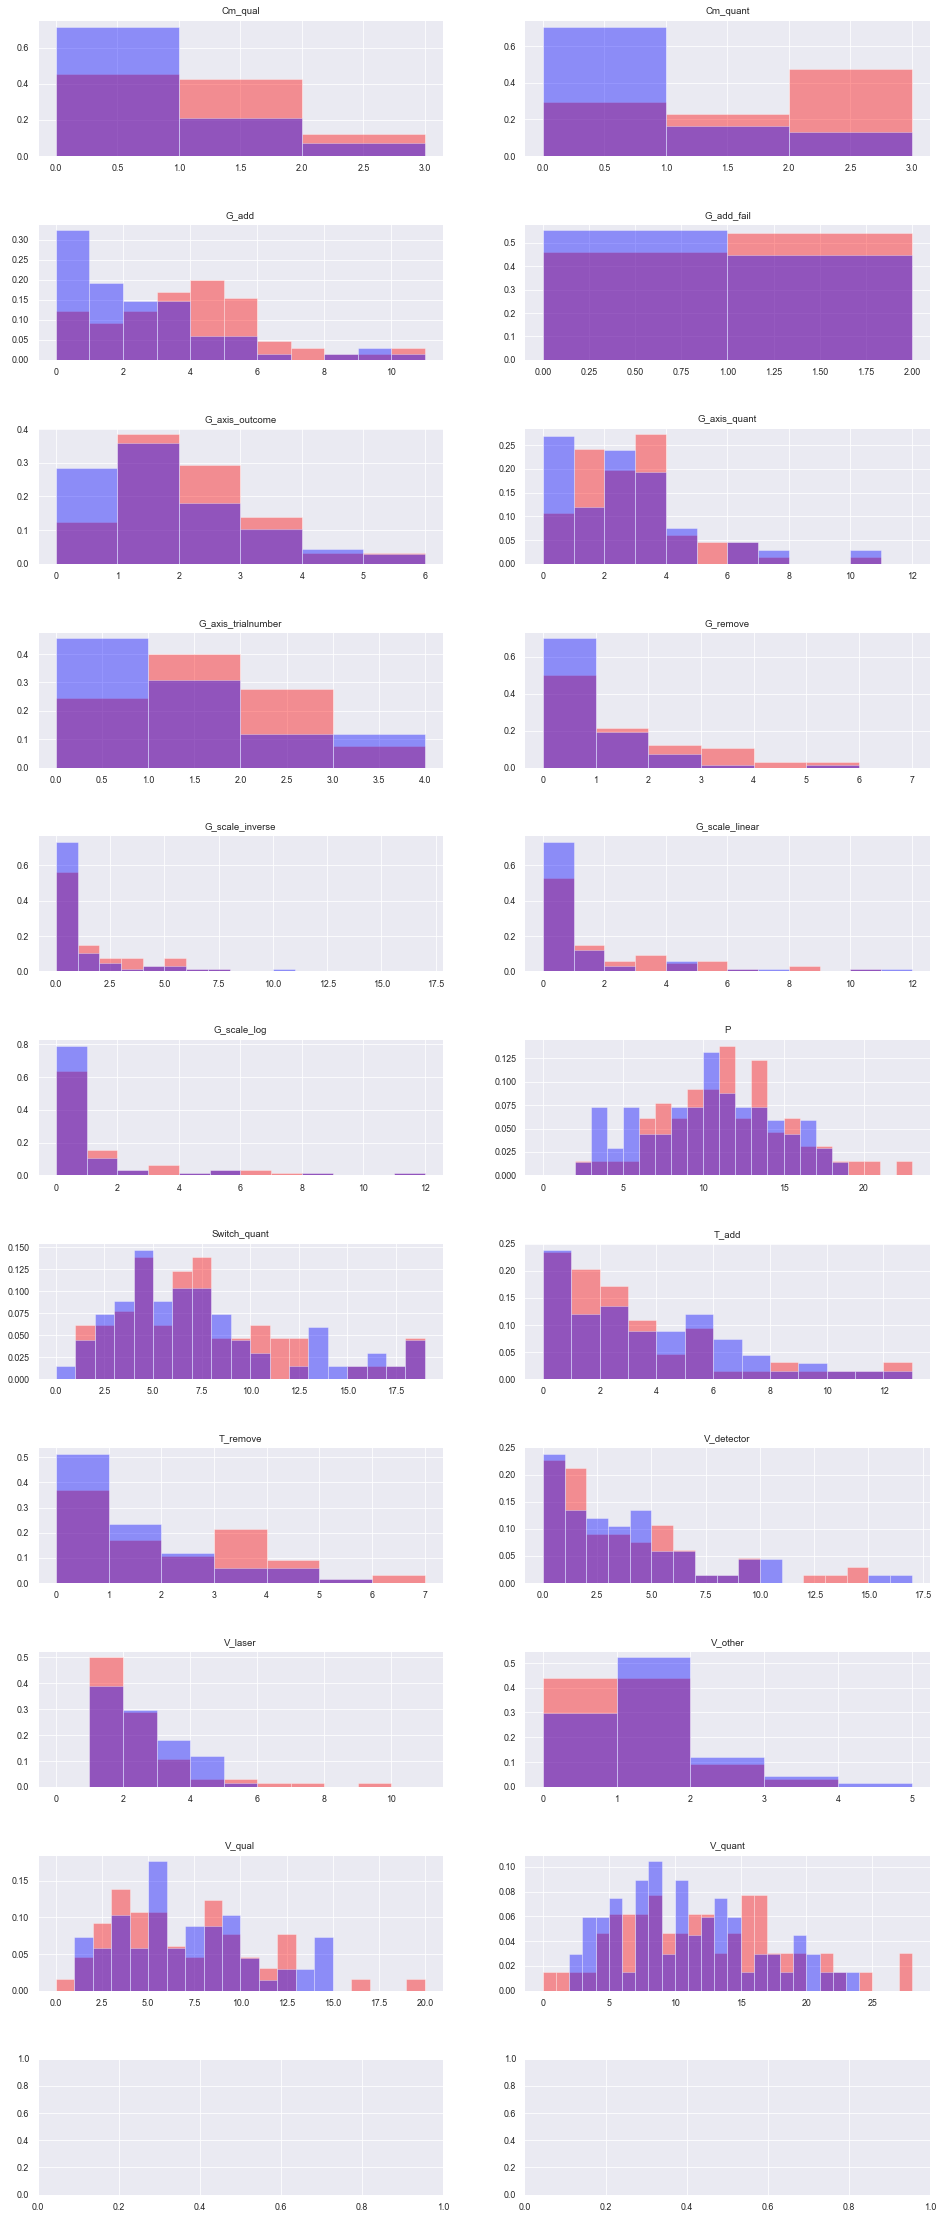

In [38]:
sns.set_style("darkgrid")
sns.set_context("paper")
fig, axes = plt.subplots(len(seqs)/2+1,2,figsize=(16,len(seqs)*2))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)


for i,s in enumerate(seqs):
#     print s
    ax = axes.flatten()[i]
    use = []
    for i,l in enumerate(levels):
        student_in_group = students_by_attribute[l]
        use.append([])
        for student in student_in_group:
            if s in freqs[student][0].keys():
                use[i].append(freqs[student][0][s])
            else:
                use[i].append(0)
                
#     print s, use
    bins = range(max(use[0]+use[1]))
    a = sns.distplot(use[0],color='red',ax=ax,kde=False,bins=bins,norm_hist=True)
    sns.distplot(use[1],color='blue',ax=ax,kde=False,bins=bins,norm_hist=True)
    ax.set_title(s);